## Objective
- compare taxonomic distribution between metagenomic reads and cosmid library sequencing reads using Kraken2 (Wood et al. 2019)
- compare taxonomic distribution between metagenomic contigs and cosmid libray sequencing contigs using CAT (von Meijenfeldt e tal. 2019)

## Quantification
- absolute read percentage classified
    - percentage establishes normalisation to the number of reads within the dataset
    - consideration is differing methodology, i.e. the cosmid library may have higher absolute percentages purely due to the replication of DNA
- percentage of classified reads (relative percentage within clasified reads only)
    - excludes unclassified reads
    - would remediate potential differences in absolute percentages classified per dataset (see above consideration)
    - would better highlight potential cloning and replication bias
- abundance order comparison, i.e. which is the most abundant, 2nd abundant within each dataset

## References
Wood, Derrick E., Jennifer Lu, and Ben Langmead. "Improved metagenomic analysis with Kraken 2." Genome biology 20 (2019): 1-13.
<br>
Von Meijenfeldt, F. B., Arkhipova, K., Cambuy, D. D., Coutinho, F. H., & Dutilh, B. E. (2019). Robust taxonomic classification of uncharted microbial sequences and bins with CAT and BAT. Genome biology, 20, 1-14.
<br>
Storey, M. A., Andreassend, S. K., Bracegirdle, J., Brown, A., Keyzers, R. A., Ackerley, D. F., ... & Owen, J. G. (2020). Metagenomic exploration of the marine sponge Mycale hentscheli uncovers multiple polyketide-producing bacterial symbionts. MBio, 11(2), e02997-19.

In [1]:
import os
from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Make a color_dict to use for BGC classes (summarised)
color_dict = {
    'terpene':'#f0e442',
    'PKS':'#e69f00',
    'bacteriocin':'#009e73',
    'NRPS':'#fabdea',
    'other':'#999999',
    'RiPP':'#56b4e9',
    'NRPS-PKS hybrid':'#f81ce5',
    'bacteriocin-RiPP hybrid':'#674ea7',
    'RiPP hybrid':'#0b5394',
    'PKS hybrid':'#fb7403',
    'mixed hybrid':'#783f04',
}

# Kraken2

In [3]:
# Make list of all Kraken report files
kraken2_base_dir = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/kraken_compare"
report_list = []
for i in os.listdir(kraken2_base_dir):
    if i.endswith(".report"):
        if i.startswith("Sp_") or i.startswith("MHpat150"):
            report_list.append(i)

In [4]:
report_list

['MHpat150_12_kraken2.report',
 'Sp_2_kraken2.report',
 'Sp_1_kraken2.report',
 'Sp_unmapped_1_250622_kraken2.report',
 'Sp_12_kraken2.report',
 'MHpat150_2_kraken2.report',
 'MHpat150_1_kraken2.report']

In [5]:
# Make a dataframe of all reports, where report name is taken from file name
df_list = []
for i in report_list:
    temp_df = pd.read_csv(os.path.join(kraken2_base_dir,i), sep='\t', header=None)
    #print(str(i.split("_kraken2")[0]))
    if '1_310821'in i:
        temp_df["sample"] = str(i.split("_1_310821_kraken2")[0])
    elif '1_250622' in i:
        temp_df["sample"] = str(i.split("_1_250622_kraken2")[0])
    else:
        temp_df["sample"] = str(i.split("_kraken2")[0])
    df_list.append(temp_df)
    
report_df = pd.concat(df_list, ignore_index=True)

In [6]:
# Show unique classification levels and inspect Domain (D) level
# paired read data produces one line per read pair 
# classification rate is higer, demonstrating that Kraken2 classifies more reads using paired input
print(report_df[3].unique())
report_df.loc[report_df[3] =='D']


['U' 'R' 'R1' 'D' 'P' 'C' 'O' 'F' 'G' 'G1' 'S' 'S1' 'F1' 'S2' 'O1' 'G2'
 'C1' 'C2' 'F2' 'F3' 'S3' 'P1' 'O2' 'D1' 'D2' 'G3' 'D3' 'D4' 'D5']


,0,1,2,3,4,5,sample
3,2.62,1937199,91539,D,2,Bacteria,MHpat150_12
11520,0.84,621897,445,D,2157,Archaea,MHpat150_12
12183,28.44,97118267,52150296,D,2,Bacteria,Sp_2
23631,0.03,105189,18,D,2157,Archaea,Sp_2
24164,28.97,98911874,52148841,D,2,Bacteria,Sp_1
35175,0.01,42261,4,D,2157,Archaea,Sp_1
35645,21.22,59979099,9887782,D,2,Bacteria,Sp_unmapped
47293,0.05,144918,10,D,2157,Archaea,Sp_unmapped
47892,34.16,116638830,48272291,D,2,Bacteria,Sp_12
59573,0.04,144947,10,D,2157,Archaea,Sp_12


In [7]:
"""
Make dataframe for phylum (P) level
Rename columns based on output format from https://github.com/DerrickWood/kraken2/wiki/Manual#output-formats
Note that numbers are shifted by -1
1: Percentage of fragments covered by the clade rooted at this taxon
2: Number of fragments covered by the clade rooted at this taxon
3: Number of fragments assigned directly to this taxon
4: A rank code, indicating (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies. Taxa that are not at any of these 10 ranks have a rank code that is formed by using the rank code of the closest ancestor rank with a number indicating the distance from that rank. E.g., "G2" is a rank code indicating a taxon is between genus and species and the grandparent taxon is at the genus rank.
5: NCBI taxonomic ID number
6: Indented scientific name
"""
phylum_df = report_df.loc[report_df[3] =='P']
print(len(phylum_df))
phylum_df = phylum_df.rename(columns={0:'percentage', 1:'# fragments clade', 2:'# fragments direct', 3:'level',
                                      4:'NCBI taxID', 5:'phylum'})
phylum_df.head(10)

319


,percentage,# fragments clade,# fragments direct,level,NCBI taxID,phylum,sample
4,1.85,1367029,120045,P,1224,Proteobacteria,MHpat150_12
5431,0.31,231340,6211,P,976,Bacteroidetes,MHpat150_12
6314,0.00,904,0,P,1090,Chlorobi,MHpat150_12
6350,0.00,168,0,P,1134404,Ignavibacteriae,MHpat150_12
6361,0.00,122,0,P,1936987,Balneolaeota,MHpat150_12
6365,0.00,529,0,P,142182,Gemmatimonadetes,MHpat150_12
6377,0.00,112,0,P,456828,Candidatus Cloacimonetes,MHpat150_12
6381,0.00,12,0,P,65842,Fibrobacteres,MHpat150_12
6390,0.15,108616,2469,P,1239,Firmicutes,MHpat150_12
8123,0.09,64089,387,P,201174,Actinobacteria,MHpat150_12


In [8]:
# Filter out phyla with less than 0.05% absolute percentage classified
phylum_df2 = phylum_df.loc[phylum_df['percentage'] >= 0.05]

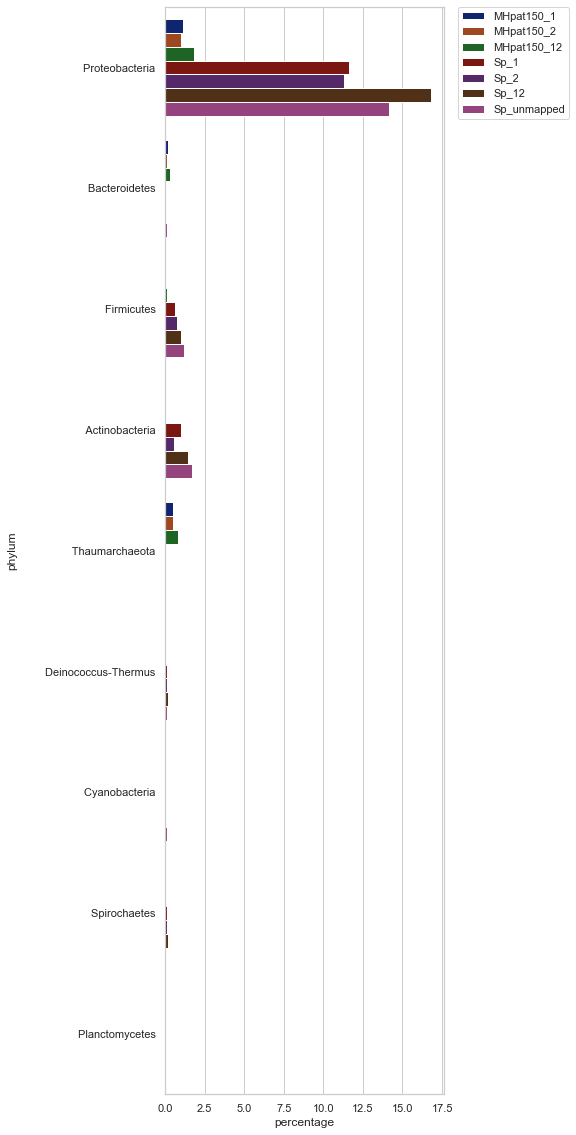

In [9]:
# This shows the higher absolute classification percentages in cloned DNA
plt.figure(figsize=(5,20))
sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=phylum_df2,
    x='percentage', y='phylum', hue='sample',
    ci="sd", palette="dark", orient='h',
    hue_order=['MHpat150_1', 'MHpat150_2','MHpat150_12','Sp_1','Sp_2','Sp_12','Sp_unmapped'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)


## Phylum percentages (relative percentages of all classified reads)
- Note that paired read runs have the same number since Kraken2 seems to treat a read pair as one comparison
- Sample (reads classified)
    - MHpat150 2567924
    - MHpat150_1 1556681
    - MHpat150_2 1414018
    - Sp 116844611
    - Sp_1 98981068
    - Sp_2 97574117
    - Sp_unmapped 60184843

In [10]:
# Make a column containing the sum of absolute read percentages classified in each sample
phylum_df_rel1 = phylum_df.copy()
print(len(phylum_df_rel1))
# phylum_df_rel1.head(10)
print(phylum_df_rel1.groupby('sample')['percentage'].sum())
phylum_df_rel1['perc_sum'] = phylum_df_rel1.groupby('sample', sort=False)['percentage'].transform('sum')
phylum_df_rel1


319
sample
MHpat150_1      1.98
MHpat150_12     3.30
MHpat150_2      1.81
Sp_1           13.66
Sp_12          19.98
Sp_2           13.10
Sp_unmapped    17.68
Name: percentage, dtype: float64


,percentage,# fragments clade,# fragments direct,level,NCBI taxID,phylum,sample,perc_sum
4,1.85,1367029,120045,P,1224,Proteobacteria,MHpat150_12,3.30
5431,0.31,231340,6211,P,976,Bacteroidetes,MHpat150_12,3.30
6314,0.00,904,0,P,1090,Chlorobi,MHpat150_12,3.30
6350,0.00,168,0,P,1134404,Ignavibacteriae,MHpat150_12,3.30
6361,0.00,122,0,P,1936987,Balneolaeota,MHpat150_12,3.30
...,...,...,...,...,...,...,...,...
82435,0.00,466,0,P,28889,Crenarchaeota,MHpat150_1,1.98
82510,0.00,1956,24,P,28890,Euryarchaeota,MHpat150_1,1.98
82829,0.00,71,0,P,1655434,Candidatus Lokiarchaeota,MHpat150_1,1.98
82832,0.00,62,0,P,2283796,Candidatus Thermoplasmatota,MHpat150_1,1.98


In [11]:
# sanity check
phylum_df_rel1.groupby('sample')['perc_sum'].value_counts()

sample       perc_sum
MHpat150_1   1.98        44
MHpat150_12  3.30        46
MHpat150_2   1.81        45
Sp_1         13.66       46
Sp_12        19.98       46
Sp_2         13.10       46
Sp_unmapped  17.68       46
Name: perc_sum, dtype: int64

In [58]:
# Compare the overall phylum sum to the domain bacteria + archaea sum
print(report_df[(report_df[3] =='D') & (report_df['sample'] =='MHpat150_12')][0].sum())
print(report_df[(report_df[3] =='D') & (report_df['sample'] =='Sp_unmapped')][0].sum())


3.46
21.27


In [12]:
# Calculate realtive percentage
phylum_df_rel2 = phylum_df_rel1.copy()
phylum_df_rel2["rel_percentage"] = phylum_df_rel2["percentage"]/phylum_df_rel2["perc_sum"]*100
phylum_df_rel2

,percentage,# fragments clade,# fragments direct,level,NCBI taxID,phylum,sample,perc_sum,rel_percentage
4,1.85,1367029,120045,P,1224,Proteobacteria,MHpat150_12,3.30,56.060606
5431,0.31,231340,6211,P,976,Bacteroidetes,MHpat150_12,3.30,9.393939
6314,0.00,904,0,P,1090,Chlorobi,MHpat150_12,3.30,0.000000
6350,0.00,168,0,P,1134404,Ignavibacteriae,MHpat150_12,3.30,0.000000
6361,0.00,122,0,P,1936987,Balneolaeota,MHpat150_12,3.30,0.000000
...,...,...,...,...,...,...,...,...,...
82435,0.00,466,0,P,28889,Crenarchaeota,MHpat150_1,1.98,0.000000
82510,0.00,1956,24,P,28890,Euryarchaeota,MHpat150_1,1.98,0.000000
82829,0.00,71,0,P,1655434,Candidatus Lokiarchaeota,MHpat150_1,1.98,0.000000
82832,0.00,62,0,P,2283796,Candidatus Thermoplasmatota,MHpat150_1,1.98,0.000000


In [55]:
# Show how many and what phyla were identified from all and individual samples
print("Across both samples there are "+str(phylum_df_rel2["phylum"].nunique())+" phyla detected")
print(phylum_df_rel2["phylum"].unique())
print(str(phylum_df_rel2[phylum_df_rel2["rel_percentage"] > 0.1]["phylum"].nunique())+" of these have abundance > 0.1%")
print(phylum_df_rel2[phylum_df_rel2["rel_percentage"] > 0.1]["phylum"].unique())

print("In MH_metagenome "+str(phylum_df_rel2[phylum_df_rel2["sample"] == "MHpat150_12"]["phylum"].nunique())+" unique phyla were detected")
print(str(len(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.1) & (phylum_df_rel2["sample"] == "MHpat150_12")]["phylum"].unique()))+" of these have abundance > 0.1%")
print(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.1) & (phylum_df_rel2["sample"] == "MHpat150_12")]["phylum"].unique())

print("In Sp_cosmid_library "+str(phylum_df_rel2[phylum_df_rel2["sample"] == "Sp_unmapped"]["phylum"].nunique())+" unique phyla were detected")
print(str(len(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.1) & (phylum_df_rel2["sample"] == "Sp_unmapped")]["phylum"].unique()))+" of these have abundance > 0.1%")
print(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.1) & (phylum_df_rel2["sample"] == "Sp_unmapped")]["phylum"].unique())

print("In MH_metagenome "+str(phylum_df_rel2[phylum_df_rel2["sample"] == "MHpat150_12"]["phylum"].nunique())+" unique phyla were detected")
print(str(len(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.5) & (phylum_df_rel2["sample"] == "MHpat150_12")]["phylum"].unique()))+" of these have abundance > 0.5%")
print(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.5) & (phylum_df_rel2["sample"] == "MHpat150_12")]["phylum"].unique())

print("In Sp_cosmid_library "+str(phylum_df_rel2[phylum_df_rel2["sample"] == "Sp_unmapped"]["phylum"].nunique())+" unique phyla were detected")
print(str(len(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.5) & (phylum_df_rel2["sample"] == "Sp_unmapped")]["phylum"].unique()))+" of these have abundance > 0.5%")
print(phylum_df_rel2[(phylum_df_rel2["rel_percentage"] > 0.5) & (phylum_df_rel2["sample"] == "Sp_unmapped")]["phylum"].unique())


Across both samples there are 46 phyla detected
['      Proteobacteria' '          Bacteroidetes' '          Chlorobi'
 '          Ignavibacteriae' '          Balneolaeota'
 '        Gemmatimonadetes' '        Candidatus Cloacimonetes'
 '        Fibrobacteres' '        Firmicutes' '        Actinobacteria'
 '          Cyanobacteria' '        Tenericutes' '        Chloroflexi'
 '        Deinococcus-Thermus' '        Armatimonadetes'
 '        Planctomycetes' '        Verrucomicrobia'
 '        Kiritimatiellaeota' '        Chlamydiae'
 '        Candidatus Omnitrophica' '      Spirochaetes'
 '      Fusobacteria' '      Nitrospirae' '      Acidobacteria'
 '      Thermotogae' '      Deferribacteres' '      Thermodesulfobacteria'
 '      Aquificae' '      Synergistetes' '      Calditrichaeota'
 '      Dictyoglomi' '      Atribacterota'
 '          Candidatus Bipolaricaulota'
 '          Candidatus Saccharibacteria' '      Chrysiogenetes'
 '      Elusimicrobia' '      Coprothermobacterota' '  

In [53]:
MHpat150_phyla_list = set(phylum_df_rel2[phylum_df_rel2["sample"] == "MHpat150_12"]["phylum"].tolist())
Sp_unmapped_phyla_list = set(phylum_df_rel2[phylum_df_rel2["sample"] == "Sp_unmapped"]["phylum"].tolist())
print(len(MHpat150_phyla_list))
print(len(Sp_unmapped_phyla_list))
print(len(MHpat150_phyla_list.union(Sp_unmapped_phyla_list)))


46
46
46


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '      Proteobacteria'),
  Text(1, 0, '          Bacteroidetes'),
  Text(2, 0, '        Firmicutes'),
  Text(3, 0, '        Actinobacteria'),
  Text(4, 0, '          Cyanobacteria'),
  Text(5, 0, '        Thaumarchaeota'),
  Text(6, 0, '        Deinococcus-Thermus'),
  Text(7, 0, '        Planctomycetes')])

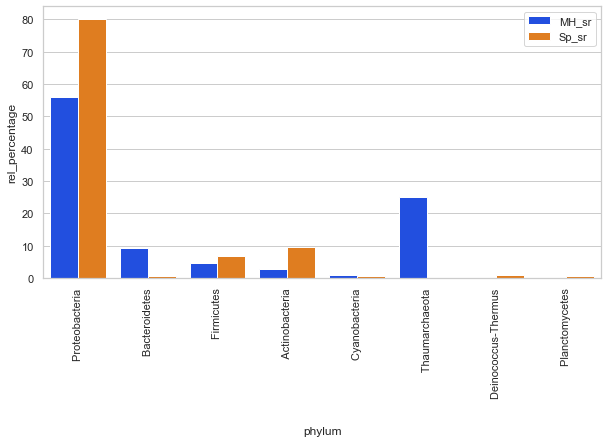

In [14]:
# Make a figure with abundant phyla (>= 0.5%) and better names
phylum_df_rel3 = phylum_df_rel2[phylum_df_rel2['rel_percentage'] >= 0.5]
phylum_df_rel3 = phylum_df_rel3.replace('Sp_unmapped','Sp_sr')
phylum_df_rel3 = phylum_df_rel3.replace('MHpat150_12','MH_sr')

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
g = sns.barplot(
    data=phylum_df_rel3.loc[phylum_df_rel3['sample'].isin(['Sp_sr','MH_sr'])],
    x='phylum', y='rel_percentage', hue='sample',
    ci="sd", palette="bright")
plt.legend(loc="upper right")
plt.xticks(rotation=90)


In [15]:
# Make a dataframe with the only the two reports of concern
MH_only_rel = phylum_df_rel3.loc[phylum_df_rel3['sample'].isin(['Sp_sr','MH_sr'])][['sample','phylum','rel_percentage']]
MH_only_rel_pivot = MH_only_rel.pivot(index='sample', columns='phylum', values='rel_percentage')
print(MH_only_rel_pivot.sum(axis=1))
MH_only_rel_pivot


sample
MH_sr    98.787879
Sp_sr    99.095023
dtype: float64


phylum,Bacteroidetes,Cyanobacteria,Actinobacteria,Deinococcus-Thermus,Firmicutes,Planctomycetes,Thaumarchaeota,Proteobacteria
sample,,,,,,,,
MH_sr,9.393939,0.909091,2.727273,NaN,4.545455,NaN,25.151515,56.060606
Sp_sr,0.565611,0.622172,9.728507,0.904977,6.674208,0.50905,NaN,80.090498


In [16]:
# # Color_map also used in Chapter 2
# color_map = {'Proteobacteria':"#990099",
#  'Acidobacteriota':"#b2df8a",
#  'Actinobacteriota':"#ff9e3d",
#  'Bacteroidota':"#33a02c",
#  'Binatota':"#a02c33",
#  'Bdellovibrionota':"#006633",
#  'Bdellovibrionota_B':"#a46502",
#  'Chloroflexota':"#e3a6c9",
#  'Chloroflexota_B':'#02437f',
#  'Crenarchaeota':'#009999',
#  'Cyanobacteria':"#cab2d6",
#  'Dadabacteria':"#a561ed",
#  'Deinococcota':"#1f78b4",
#  'Gemmatimonadota':'#e3bba6',
#  'Latescibacterota':'#5d6d3c',
#  'Nitrospirota':"#F47BE7",
#  'Patescibacteria':"#dcdc23", 
#  'Poribacteria':"#e84f51",
#  'Spirochaetota':"#fb9a99",
#  'Tectomicrobia':"#000000",
#  'Verrucomicrobiota':'#a6cee3',
#  'UBA8248':"#9c9c9c"}

Text(0, 0.5, '')

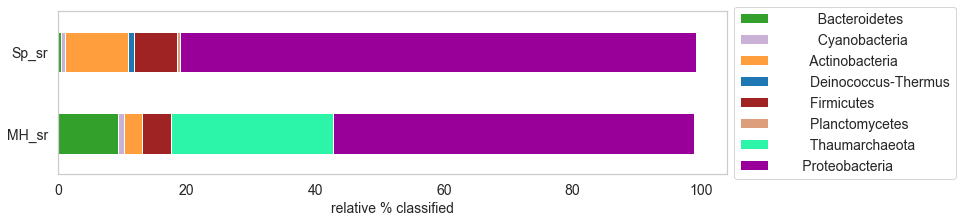

In [17]:
# Colors need to be in order below
# No colors for some phyla
# Bacteroidetes,Cyanobacteria,Actinobacteria,Deinococcus-Thermus,Firmicutes,Planctomycetes,Thaumarchaeota,Proteobacteria

MH_only_rel_pivot.fillna(0).plot.barh(stacked=True, grid=False, figsize=(12,3),
                                             color=['#33a02c',"#cab2d6","#ff9e3d","#1f78b4",'#A02323','#DD9E7B','#2CF5AA',"#990099"])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('relative % classified', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(None)

#plt.savefig("/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/Metagenome_v_cosmid_final_thesis_kraken2_plot.pdf", format='pdf', bbox_inches='tight')


### E. coli percentage in the data (absolute percentage of all reads)

In [18]:
# Make a dataframe quantifying the abundance of E. coli
E_coli_df = report_df.loc[report_df[3] == 'S']
E_coli_df = report_df.loc[report_df[5].str.contains('Escherichia coli')]
E_coli_percentages = E_coli_df.groupby('sample')[0].sum()

# Make a dataframe quantifying the abundance of Proteobacteria
Proteo_df = report_df.loc[report_df[3] == 'P']
Proteo_df = report_df.loc[report_df[5].str.contains('Proteobacteria')]
Proteo_percentages = Proteo_df.groupby('sample')[0].sum()

# Merge the dataframes
E_coli_Proteo_df = pd.merge(E_coli_percentages, Proteo_percentages, left_index=True, right_index=True)
E_coli_Proteo_df = E_coli_Proteo_df.rename(columns={'0_x':'E. coli','0_y':'Proteobacteria'})
E_coli_Proteo_df

,E. coli,Proteobacteria
sample,,
MHpat150_1,0.00,1.16
MHpat150_12,0.01,1.85
MHpat150_2,0.00,1.02
Sp_1,0.33,11.62
Sp_12,0.55,16.78
Sp_2,0.39,11.33
Sp_unmapped,0.28,14.16


In [19]:
E_coli_Proteo_df.loc[['Sp_1','Sp_12','Sp_2','Sp_unmapped']]

,E. coli,Proteobacteria
sample,,
Sp_1,0.33,11.62
Sp_12,0.55,16.78
Sp_2,0.39,11.33
Sp_unmapped,0.28,14.16


<AxesSubplot:xlabel='Proteobacteria', ylabel='E. coli'>

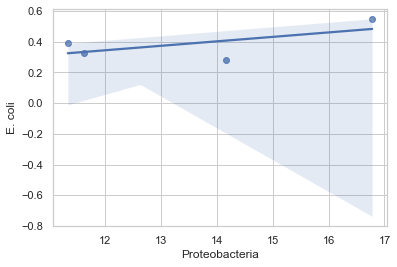

In [20]:
# Shows a weak relation with Sp_unmapped data used here the least related
sns.regplot(data=E_coli_Proteo_df.loc[['Sp_1','Sp_12','Sp_2','Sp_unmapped']], x='Proteobacteria', y='E. coli', fit_reg=True)

# CAT

In [21]:
CAT_base_dir = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/CAT_compare"

In [22]:
# Read in the summary files
# Since not strictly in tsv format, need to skip intro rows
MH_sr_summary_df = pd.read_csv(os.path.join(CAT_base_dir,"MHpat_150_summary.txt"), skiprows=3, header=0, sep='\t')
MH_hy_summary_df = pd.read_csv(os.path.join(CAT_base_dir,"MHpat_all_summary.txt"), skiprows=3, header=0, sep='\t')
Sp_sr_summary_df = pd.read_csv(os.path.join(CAT_base_dir,"Sp_sr_summary.txt"), skiprows=3, header=0, sep='\t')
Sp_hy_alt3_summary_df = pd.read_csv(os.path.join(CAT_base_dir,"Sp_hy_alt3_summary.txt"), skiprows=3, header=0, sep='\t')



In [23]:
Sp_hy_alt3_summary_df.head(5)

,# rank,clade,number of contigs,number of ORFs,number of positions
0,superkingdom,Bacteria,930,81649,75576368
1,superkingdom,Eukaryota,149,2000,2519398
2,superkingdom,no support,37,1198,1203515
3,superkingdom,Archaea,9,177,136791
4,superkingdom,Viruses,3,80,65998


In [24]:
# Make a list of all the phyla identified
MH_sr_summary_phyla_list = MH_sr_summary_df[MH_sr_summary_df['# rank'] == 'phylum']['clade'].unique().tolist()
print(len(MH_sr_summary_phyla_list))
MH_hy_summary_phyla_list = MH_hy_summary_df[MH_hy_summary_df['# rank'] == 'phylum']['clade'].unique().tolist()
print(len(MH_hy_summary_phyla_list))
Sp_sr_summary_phyla_list = Sp_sr_summary_df[Sp_sr_summary_df['# rank'] == 'phylum']['clade'].unique().tolist()
print(len(Sp_sr_summary_phyla_list))
Sp_hy_alt3_summary_phyla_list = Sp_hy_alt3_summary_df[Sp_hy_alt3_summary_df['# rank'] == 'phylum']['clade'].unique().tolist()
print(len(Sp_hy_alt3_summary_phyla_list))

phyla_list = MH_sr_summary_phyla_list+MH_hy_summary_phyla_list+Sp_sr_summary_phyla_list+Sp_hy_alt3_summary_phyla_list
print(len(set(phyla_list)))

46
27
30
27
53


In [25]:
print(set(phyla_list))

{nan, 'Nitrospirae', 'Basidiomycota', 'Ascomycota', 'Spirochaetes', 'Annelida', 'Firmicutes', 'Evosea', 'Chlorophyta', 'Ciliophora', 'Mollusca', 'Platyhelminthes', 'Actinobacteria', 'Candidatus Cloacimonetes', 'Nematoda', 'Rotifera', 'Mucoromycota', 'Cnidaria', 'Cyanobacteria', 'Acidobacteria', 'Proteobacteria', 'Kiritimatiellaeota', 'Gemmatimonadetes', 'Candidatus Heimdallarchaeota', 'Candidatus Dadabacteria', 'Hemichordata', 'Chytridiomycota', 'Microsporidia', 'Planctomycetes', 'Priapulida', 'Lentisphaerae', 'Porifera', 'Candidatus Latescibacteria', 'Echinodermata', 'Chlamydiae', 'Verrucomicrobia', 'Uroviricota', 'Zoopagomycota', 'Perkinsozoa', 'Tardigrada', 'Arthropoda', 'Streptophyta', 'Chordata', 'no support', 'Placozoa', 'Haptista', 'Euryarchaeota', 'Euglenozoa', 'Bryozoa', 'Chloroflexi', 'Thaumarchaeota', 'Bacteroidetes', 'Candidatus Tectomicrobia'}


In [26]:
# How many contigs nan and no support are there?
print(len(MH_sr_summary_df[(MH_sr_summary_df['# rank'] == 'phylum') & (MH_sr_summary_df['clade'] == 'nan')]))
display(MH_sr_summary_df[(MH_sr_summary_df['# rank'] == 'phylum') & (MH_sr_summary_df['clade'] == 'no support')])
print(len(MH_hy_summary_df[(MH_hy_summary_df['# rank'] == 'phylum') & (MH_hy_summary_df['clade'] == 'nan')]))
display(MH_hy_summary_df[(MH_hy_summary_df['# rank'] == 'phylum') & (MH_hy_summary_df['clade'] == 'no support')])
print(len(Sp_sr_summary_df[(Sp_sr_summary_df['# rank'] == 'phylum') & (Sp_sr_summary_df['clade'] == 'nan')]))
display(Sp_sr_summary_df[(Sp_sr_summary_df['# rank'] == 'phylum') & (Sp_sr_summary_df['clade'] == 'no support')])
print(len(Sp_hy_alt3_summary_df[(Sp_hy_alt3_summary_df['# rank'] == 'phylum') & (Sp_hy_alt3_summary_df['clade'] == 'nan')]))
display(Sp_hy_alt3_summary_df[(Sp_hy_alt3_summary_df['# rank'] == 'phylum') & (Sp_hy_alt3_summary_df['clade'] == 'no support')])


0


,# rank,clade,number of contigs,number of ORFs,number of positions
6,phylum,no support,4332,33103,38575058


0


,# rank,clade,number of contigs,number of ORFs,number of positions
5,phylum,no support,4328,226282,307297272


0


,# rank,clade,number of contigs,number of ORFs,number of positions
8,phylum,no support,2259,28562,31020382


0


,# rank,clade,number of contigs,number of ORFs,number of positions
6,phylum,no support,280,11840,11979374


In [27]:
# Compiled list of phyla found in the different summary.txt files
Prok_list = ["Proteobacteria", "Candidatus Latescibacteria", "Acidobacteria", "Verrucomicrobia", 'Firmicutes',
"Planctomycetes", "Nitrospirae", "Kiritimatiellaeota", "Actinobacteria", "Bacteroidetes", "Cyanobacteria",
"Gemmatimonadetes", "Chloroflexi", "Candidatus Dadabacteria", "Thaumarchaeota", "Candidatus Tectomicrobia", "Lentisphaerae", 
"Candidatus Cloacimonetes", "Euryarchaeota", "Spirochaetes", "Chlamydiae", "Candidatus Heimdallarchaeota"]

# List of eukaryotic phyla: no support, NaN, Porifera, Euglenozoa, Haptista, Chordata, Ciliophora, Echinodermata,
# Nematoda, Arthropoda, Cnidaria, Mollusca, Rotifera, Perkinsozoa, Priapulida, Annelida, Hemichordata, Evosea,
# Platyhelminthes, Placozoa, Tardigrada, Microsporidia, Bryozoa
# List of viral phyla: Uroviricota
# List of fungal phyla: Mucoromycota, Zoopagomycota, Basidiomycota, Ascomycota, Chytridiomycota
# List of plant phyla: Streptophyta, Chlorophyta

# Check number of prokaryotic and total phyla
print("MH_sr")
print(len(MH_sr_summary_df[(MH_sr_summary_df["# rank"] == 'phylum') & (MH_sr_summary_df["clade"].isin(Prok_list))]))
print(len(MH_sr_summary_df[(MH_sr_summary_df["# rank"] == 'phylum') & (MH_sr_summary_df["clade"].isin(Prok_list) == False)]))
print(len(MH_sr_summary_df[MH_sr_summary_df["# rank"] == 'phylum']))
print("MH_hy")
print(len(MH_hy_summary_df[(MH_hy_summary_df["# rank"] == 'phylum') & (MH_hy_summary_df["clade"].isin(Prok_list))]))
print(len(MH_hy_summary_df[(MH_hy_summary_df["# rank"] == 'phylum') & (MH_hy_summary_df["clade"].isin(Prok_list) == False)]))
print(len(MH_hy_summary_df[MH_hy_summary_df["# rank"] == 'phylum']))
print("Sp_sr")
print(len(Sp_sr_summary_df[(Sp_sr_summary_df["# rank"] == 'phylum') & (Sp_sr_summary_df["clade"].isin(Prok_list))]))
print(len(Sp_sr_summary_df[(Sp_sr_summary_df["# rank"] == 'phylum') & (Sp_sr_summary_df["clade"].isin(Prok_list) == False)]))
print(len(Sp_sr_summary_df[Sp_sr_summary_df["# rank"] == 'phylum']))
print("Sp_hy_alt3")
print(len(Sp_hy_alt3_summary_df[(Sp_hy_alt3_summary_df["# rank"] == 'phylum') & (Sp_hy_alt3_summary_df["clade"].isin(Prok_list))]))
print(len(Sp_hy_alt3_summary_df[(Sp_hy_alt3_summary_df["# rank"] == 'phylum') & (Sp_hy_alt3_summary_df["clade"].isin(Prok_list) == False)]))
print(len(Sp_hy_alt3_summary_df[Sp_hy_alt3_summary_df["# rank"] == 'phylum']))



MH_sr
19
27
46
MH_hy
11
16
27
Sp_sr
16
14
30
Sp_hy_alt3
16
11
27


In [28]:
# Make the dataframes for prokaryotic contigs identified at the phylum level and add a sample name
MH_sr_summary_prok_df = MH_sr_summary_df[(MH_sr_summary_df["# rank"] == 'phylum') & (MH_sr_summary_df["clade"].isin(Prok_list))]
MH_sr_summary_prok_df = MH_sr_summary_prok_df.assign(sample = "MH_sr")

MH_hy_summary_prok_df = MH_hy_summary_df[(MH_hy_summary_df["# rank"] == 'phylum') & (MH_hy_summary_df["clade"].isin(Prok_list))]
MH_hy_summary_prok_df = MH_hy_summary_prok_df.assign(sample = "MH_hy")

Sp_sr_summary_prok_df = Sp_sr_summary_df[(Sp_sr_summary_df["# rank"] == 'phylum') & (Sp_sr_summary_df["clade"].isin(Prok_list))]
Sp_sr_summary_prok_df = Sp_sr_summary_prok_df.assign(sample = "Sp_sr")

Sp_hy_alt3_summary_prok_df = Sp_hy_alt3_summary_df[(Sp_hy_alt3_summary_df["# rank"] == 'phylum') & (Sp_hy_alt3_summary_df["clade"].isin(Prok_list))]
Sp_hy_alt3_summary_prok_df = Sp_hy_alt3_summary_prok_df.assign(sample = "Sp_hy")


In [64]:
# What phyla are unique to what assembly?
MH_sr_prok_phyla_list = MH_sr_summary_prok_df['clade'].tolist()
MH_hy_prok_phyla_list = MH_hy_summary_prok_df['clade'].tolist()
Sp_sr_prok_phyla_list = Sp_sr_summary_prok_df['clade'].tolist()
Sp_hy_prok_phyla_list = Sp_hy_alt3_summary_prok_df['clade'].tolist()

for i in MH_sr_prok_phyla_list:
    if i not in (MH_hy_prok_phyla_list+Sp_sr_prok_phyla_list+Sp_hy_prok_phyla_list):
        print(i+' is unique to MH_sr')

for i in MH_hy_prok_phyla_list:
    if i not in (MH_sr_prok_phyla_list+Sp_sr_prok_phyla_list+Sp_hy_prok_phyla_list):
        print(i+' is unique to MH_hy')
        
for i in Sp_sr_prok_phyla_list:
    if i not in (MH_hy_prok_phyla_list+MH_sr_prok_phyla_list+Sp_hy_prok_phyla_list):
        print(i+' is unique to Sp_sr')
        
for i in Sp_hy_prok_phyla_list:
    if i not in (MH_hy_prok_phyla_list+Sp_sr_prok_phyla_list+MH_sr_prok_phyla_list):
        print(i+' is unique to Sp_hy')

Firmicutes is unique to MH_sr
Euryarchaeota is unique to MH_sr
Spirochaetes is unique to MH_sr
Chlamydiae is unique to MH_sr
Candidatus Cloacimonetes is unique to MH_hy
Candidatus Heimdallarchaeota is unique to Sp_hy


In [29]:
# Make a summary dataframe and a new column with the relative percentage of bases and percentage of ORFs accounted for
summary_prok_df = pd.concat([MH_sr_summary_prok_df,MH_hy_summary_prok_df,Sp_sr_summary_prok_df,Sp_hy_alt3_summary_prok_df])
print(summary_prok_df.groupby('sample', sort=False)['number of positions'].sum())
summary_prok_df['position_sum'] = summary_prok_df.groupby('sample', sort=False)['number of positions'].transform('sum')
summary_prok_df["perc_length"] = summary_prok_df['number of positions']/summary_prok_df['position_sum']*100
print(summary_prok_df.groupby('sample', sort=False)['number of ORFs'].sum())
summary_prok_df['ORF_sum'] = summary_prok_df.groupby('sample', sort=False)['number of ORFs'].transform('sum')
summary_prok_df["perc_ORFs"] = summary_prok_df['number of ORFs']/summary_prok_df['ORF_sum']*100



sample
MH_sr      74847319
MH_hy      88857527
Sp_sr    1212564102
Sp_hy      66406026
Name: number of positions, dtype: int64
sample
MH_sr      71468
MH_hy      82419
Sp_sr    1172362
Sp_hy      72419
Name: number of ORFs, dtype: int64


In [30]:
# Sanity check
print(summary_prok_df.groupby('sample')['position_sum'].value_counts())
print(summary_prok_df.groupby('sample')['ORF_sum'].value_counts())


sample  position_sum
MH_hy   88857527        11
MH_sr   74847319        19
Sp_hy   66406026        16
Sp_sr   1212564102      16
Name: position_sum, dtype: int64
sample  ORF_sum
MH_hy   82419      11
MH_sr   71468      19
Sp_hy   72419      16
Sp_sr   1172362    16
Name: ORF_sum, dtype: int64


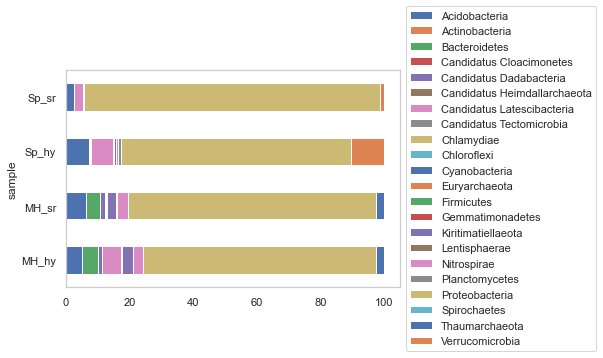

In [31]:
# Make a barplot figure
summary_prok_pivot = summary_prok_df[["clade","perc_length","sample"]].pivot(index="sample", columns='clade', values="perc_length")
axes = summary_prok_pivot.plot.barh(stacked=True, grid=False,)
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [32]:
summary_prok_pivot

clade,Acidobacteria,Actinobacteria,Bacteroidetes,Candidatus Cloacimonetes,Candidatus Dadabacteria,Candidatus Heimdallarchaeota,Candidatus Latescibacteria,Candidatus Tectomicrobia,Chlamydiae,Chloroflexi,...,Firmicutes,Gemmatimonadetes,Kiritimatiellaeota,Lentisphaerae,Nitrospirae,Planctomycetes,Proteobacteria,Spirochaetes,Thaumarchaeota,Verrucomicrobia
sample,,,,,,,,,,,,,,,,,,,,,
MH_hy,5.184037,NaN,4.848212,0.02693,1.308327,NaN,5.927554,0.281797,NaN,NaN,...,NaN,NaN,3.485238,NaN,3.101393,NaN,73.274518,NaN,2.394820,0.167174
MH_sr,6.419944,0.026331,4.413622,NaN,1.571857,NaN,0.046795,0.244275,0.007159,0.019265,...,0.071658,NaN,3.069680,0.140227,3.451530,0.132705,77.773796,0.009074,2.509735,0.032745
Sp_hy,7.284410,0.269837,0.283869,NaN,0.063436,0.010817,6.952227,0.012323,NaN,0.107468,...,NaN,0.083062,0.643095,NaN,0.687531,0.993484,71.957193,NaN,0.195175,10.366799
Sp_sr,2.599571,0.058804,0.056272,NaN,0.010966,NaN,2.620625,0.000455,NaN,0.014590,...,NaN,0.020356,0.103761,0.000413,0.115506,0.175152,92.810760,NaN,0.002343,1.389752


In [33]:
summary_prok_pivot[summary_prok_pivot > 0.5].dropna(axis=1, how='all')

clade,Acidobacteria,Bacteroidetes,Candidatus Dadabacteria,Candidatus Latescibacteria,Kiritimatiellaeota,Nitrospirae,Planctomycetes,Proteobacteria,Thaumarchaeota,Verrucomicrobia
sample,,,,,,,,,,
MH_hy,5.184037,4.848212,1.308327,5.927554,3.485238,3.101393,NaN,73.274518,2.394820,NaN
MH_sr,6.419944,4.413622,1.571857,NaN,3.069680,3.451530,NaN,77.773796,2.509735,NaN
Sp_hy,7.284410,NaN,NaN,6.952227,0.643095,0.687531,0.993484,71.957193,NaN,10.366799
Sp_sr,2.599571,NaN,NaN,2.620625,NaN,NaN,NaN,92.810760,NaN,1.389752


In [34]:
# Color_map also used in Chapter 2
# color_map = {'Proteobacteria':"#990099",
#  'Acidobacteriota':"#b2df8a",
#  'Actinobacteriota':"#ff9e3d",
#  'Bacteroidota':"#33a02c",
#  'Binatota':"#a02c33",
#  'Bdellovibrionota':"#006633",
#  'Bdellovibrionota_B':"#a46502",
#  'Chloroflexota':"#e3a6c9",
#  'Chloroflexota_B':'#02437f',
#  'Crenarchaeota':'#009999',
#  'Cyanobacteria':"#cab2d6",
#  'Dadabacteria':"#a561ed",
#  'Deinococcota':"#1f78b4",
#  'Gemmatimonadota':'#e3bba6',
#  'Latescibacterota':'#5d6d3c',
#  'Nitrospirota':"#F47BE7",
#  'Patescibacteria':"#dcdc23", 
#  'Poribacteria':"#e84f51",
#  'Spirochaetota':"#fb9a99",
#  'Tectomicrobia':"#000000",
#  'Verrucomicrobiota':'#a6cee3',
#  'UBA8248':"#9c9c9c"}

Text(0, 0.5, '')

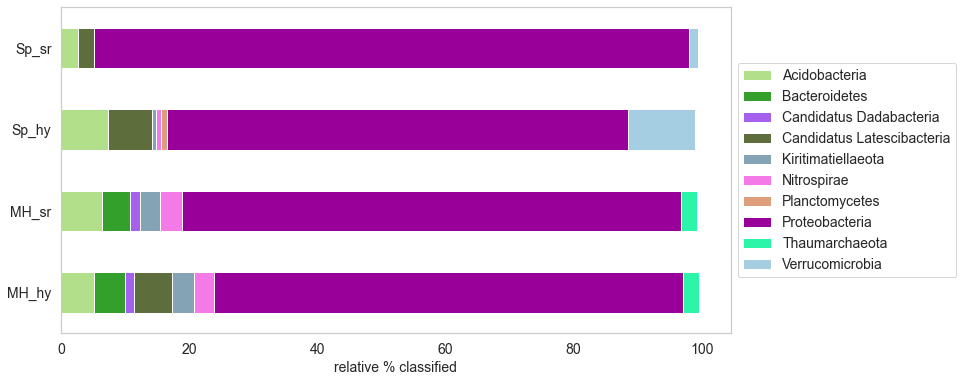

In [35]:
# Make the final barplot figure with only above 0.5%
summary_prok_pivot_excl_low = summary_prok_df[["clade","perc_length","sample"]].pivot(index="sample", columns='clade', values="perc_length")
summary_prok_pivot_excl_low = summary_prok_pivot_excl_low[summary_prok_pivot_excl_low > 0.5].dropna(axis=1, how='all')

# Colors need to be in order below
# Acidobacteria,Bacteroidetes,Candidatus Dadabacteria,Candidatus Latescibacteria,Kiritimatiellaeota,Nitrospirae,Planctomycetes,Proteobacteria,Thaumarchaeota,Verrucomicrobia
summary_prok_pivot_excl_low.plot.barh(stacked=True, grid=False, figsize=(12,6),
                                             color=['#b2df8a',"#33a02c","#a561ed","#5d6d3c",'#84a4b5','#F47BE7','#DD9E7B',"#990099",'#2CF5AA','#a6cee3'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('relative % classified', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(None)
# plt.savefig("/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/Metagenome_v_cosmid_final_thesis_CAT_plot.pdf", format='pdf', bbox_inches='tight')


# MAG-based comparison using 26 HQ MAGs from Storey et al. 2020
- Note that ref_stats doesn't account for regions not covered by mapping and seems to overestimate coverage

In [36]:
# MH seqeuncing output mapped was 22142208361 bases
MH_ref_stats_file = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/MAG_and_BGC_mapping_comparison/refstats_MHpat150.tsv"
# Sp sequencing output mapped was 102430798319 bases
Sp_ref_stats_file = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/MAG_and_BGC_mapping_comparison/refstats_Sp.tsv"
102430798319/22142208361

4.626042563099337

In [37]:
MH_ref_stats_df = pd.read_csv(MH_ref_stats_file, sep="\t")
Sp_ref_stats_df = pd.read_csv(Sp_ref_stats_file, sep="\t")
print(MH_ref_stats_df['%unambiguousReads'].sum())
print(Sp_ref_stats_df['%unambiguousReads'].sum())
Sp_ref_stats_df.head(5)

15.12482
68.08565


,#name,%unambiguousReads,unambiguousMB,%ambiguousReads,ambiguousMB,unambiguousReads,ambiguousReads,assignedReads,assignedBases
0,GCA_012103455.1_ASM1210345v1_genomic,35.77066,36641.2791,0.09623,98.5671,244275194,657114,244883398,36732509700
1,GCA_012103325.1_ASM1210332v1_genomic,10.94275,11209.0815,0.02615,26.7843,74727210,178562,74727210,11209081500
2,GCA_012103505.1_ASM1210350v1_genomic,5.59424,5730.4023,0.02146,21.9810,38202682,146540,38332294,5749844100
3,GCA_012103295.1_ASM1210329v1_genomic,4.82127,4938.6198,0.01530,15.6696,32924132,104464,33014508,4952176200
4,GCA_012103305.1_ASM1210330v1_genomic,3.08209,3157.1007,0.00248,2.5374,21047338,16916,21050768,3157615200


In [38]:
# MH seqeuncing output mapped was 22142208361 bases
MH_covstats_file = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/MAG_and_BGC_mapping_comparison/covstats_MHpat150.tsv"
MH_covstats_df = pd.read_csv(MH_covstats_file, sep="\t")

# Sp sequencing output mapped was 102430798319 bases
Sp_covstats_file = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/MAG_and_BGC_mapping_comparison/covstats_Sp.tsv"
Sp_covstats_df = pd.read_csv(Sp_covstats_file, sep="\t")

print("Ratio in sequencing output Sp/MH is:")
102430798319/22142208361

Ratio in sequencing output Sp/MH is:


4.626042563099337

In [39]:
# Obtain length information for all the MAGs
basedir = "/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/MAG_and_BGC_mapping_comparison/ncbi-genomes-2022-08-21/"
MAG_length_dict = {}
for i in os.listdir(basedir):
    if i.endswith(".fna"):
        name = i.split(".fna")[0]
        seq_it = SeqIO.parse(basedir+"/"+i, "fasta")
        MAG_length = 0
        for seq in seq_it:
            MAG_length += len(seq)
        MAG_length_dict[name] = MAG_length

MAG_length_df = pd.DataFrame.from_dict(MAG_length_dict, orient='index', columns=["MAG_length"])


In [40]:
# Should aim to account for length of contig in relation to MAG total length before calculating overall coverage 
print(len(set(MH_covstats_df["#ID"].str.split("$", expand=True)[0].tolist())))
print(len(set(Sp_covstats_df["#ID"].str.split("$", expand=True)[0].tolist())))
MAG_series = set(MH_covstats_df["#ID"].str.split("$", expand=True)[0].tolist())

26
26


In [41]:
MH_covstats_df["#name"] = MH_covstats_df["#ID"].str.split("$", expand=True)[0]
MH_cov_summary = pd.merge(MH_covstats_df,MAG_length_df, right_index=True, left_on="#name")
MH_cov_summary["contig_proportion"] = MH_cov_summary["Length"]/MH_cov_summary["MAG_length"]
MH_cov_summary["len_norm_cov"] = MH_cov_summary["contig_proportion"]*MH_cov_summary["Covered_percent"]/100*MH_cov_summary["Avg_fold"]
MH_cov_summary


,#ID,Avg_fold,Length,Ref_GC,Covered_percent,Covered_bases,Plus_reads,Minus_reads,Read_GC,Median_fold,Std_Dev,#name,MAG_length,contig_proportion,len_norm_cov
0,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,25.4429,1470802,0.6442,99.9962,1470746,124737,124747,0.6448,25,6.97,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.305469,7.771726
1,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,22.1880,1042472,0.6397,99.9999,1042471,77048,77161,0.6406,22,6.16,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.216510,4.803915
2,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,0.0543,11041,0.6643,5.0358,556,2,2,0.6800,0,0.24,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.002293,0.000006
3,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,23.0810,628496,0.6449,99.9984,628486,48361,48357,0.6457,23,6.15,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.130532,3.012752
4,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,25.5339,106595,0.6481,99.9887,106583,9081,9073,0.6482,25,6.60,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.022139,0.565221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,1.2660,4681,0.6138,65.1784,3051,20,20,0.6135,1,1.49,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002812,0.002320
2707,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,1.6379,28567,0.6351,75.3842,21535,156,156,0.6396,1,1.42,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.017159,0.021186
2708,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,1.6939,4339,0.6011,75.2478,3265,24,25,0.6000,1,1.57,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002606,0.003322
2709,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,2.0790,4329,0.6272,82.8598,3587,30,30,0.6319,2,1.44,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002600,0.004479


In [42]:
# Sanity check on MAG length from contig length
MH_cov_summary_length_check_df = MH_cov_summary.groupby("#name")["Length"].sum().to_frame()
pd.merge(MH_cov_summary_length_check_df, MAG_length_df, left_on="Length", right_on="MAG_length")


,Length,MAG_length
0,4814895,4814895
1,2755821,2755821
2,3687245,3687245
3,3076004,3076004
4,4111711,4111711
5,6333795,6333795
6,4021902,4021902
7,3364909,3364909
8,4488480,4488480
9,5786418,5786418


In [43]:
Sp_covstats_df["#name"] = Sp_covstats_df["#ID"].str.split("$", expand=True)[0]
Sp_cov_summary = pd.merge(Sp_covstats_df,MAG_length_df, right_index=True, left_on="#name")
Sp_cov_summary["contig_proportion"] = Sp_cov_summary["Length"]/Sp_cov_summary["MAG_length"]
Sp_cov_summary["len_norm_cov"] = Sp_cov_summary["contig_proportion"]*Sp_cov_summary["Covered_percent"]/100*Sp_cov_summary["Avg_fold"]
Sp_cov_summary


,#ID,Avg_fold,Length,Ref_GC,Covered_percent,Covered_bases,Plus_reads,Minus_reads,Read_GC,Median_fold,Std_Dev,#name,MAG_length,contig_proportion,len_norm_cov
0,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,350.5176,1470802,0.6442,99.8956,1469267,1720509,1716558,0.6432,292,276.56,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.305469,106.960538
1,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,247.0863,1042472,0.6397,95.3603,994104,858776,858459,0.6384,180,214.46,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.216510,51.014526
2,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,0.0000,11041,0.6643,0.0000,0,0,0,0.0000,0,0.00,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.002293,0.000000
3,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,210.5239,628496,0.6449,97.8617,615057,441311,440843,0.6452,164,158.58,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.130532,26.892418
4,GCA_012103255.1_ASM1210325v1_genomic$WLXD01000...,201.3053,106595,0.6481,100.0000,106595,71625,71489,0.6478,189,102.24,GCA_012103255.1_ASM1210325v1_genomic,4814895,0.022139,4.456616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,0.0000,4681,0.6138,0.0000,0,0,0,0.0000,0,0.00,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002812,0.000000
2707,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,0.0000,28567,0.6351,0.0000,0,0,0,0.0000,0,0.00,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.017159,0.000000
2708,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,0.0000,4339,0.6011,0.0000,0,0,0,0.0000,0,0.00,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002606,0.000000
2709,GCA_012103615.1_ASM1210361v1_genomic$WLWK01000...,0.0000,4329,0.6272,0.0000,0,0,0,0.0000,0,0.00,GCA_012103615.1_ASM1210361v1_genomic,1664881,0.002600,0.000000


In [44]:
# Taxonomy df (as identified by PGAP on NCBI and as identified by GTDB-tk and new tax in Storey et al. 2020)
tax_df = pd.DataFrame({"#name":['GCA_014075315.1_ASM1407531v1_genomic','GCA_012103575.1_ASM1210357v1_genomic',
 'GCA_012103415.1_ASM1210341v1_genomic','GCA_012103375.1_ASM1210337v1_genomic','GCA_014075215.1_ASM1407521v1_genomic',
 'GCA_014075275.1_ASM1407527v1_genomic','GCA_012103405.1_ASM1210340v1_genomic','GCA_012103505.1_ASM1210350v1_genomic',
 'GCA_014075255.1_ASM1407525v1_genomic','GCA_012103295.1_ASM1210329v1_genomic','GCA_012103255.1_ASM1210325v1_genomic',
 'GCA_012103325.1_ASM1210332v1_genomic','GCA_012103275.1_ASM1210327v1_genomic','GCA_012103535.1_ASM1210353v1_genomic',
 'GCA_012103475.1_ASM1210347v1_genomic','GCA_012103305.1_ASM1210330v1_genomic','GCA_012103455.1_ASM1210345v1_genomic',
 'GCA_012103395.1_ASM1210339v1_genomic','GCA_014075295.1_ASM1407529v1_genomic','GCA_012103555.1_ASM1210355v1_genomic',
 'GCA_012103315.1_ASM1210331v1_genomic','GCA_012103615.1_ASM1210361v1_genomic','GCA_012103655.1_ASM1210365v1_genomic',
 'GCA_012103605.1_ASM1210360v1_genomic','GCA_012103595.1_ASM1210359v1_genomic','GCA_012103495.1_ASM1210349v1_genomic'],
            "SAMN":["SAMN12903703","SAMN12903682",
                      "SAMN12903691","SAMN12903695","SAMN12903683",
                     "SAMN12903694","SAMN12903693","SAMN12903685",
                     "SAMN12903688","SAMN12903699","SAMN12903702",
                     "SAMN12903696","SAMN12903701","SAMN12903686",
                     "SAMN12903689","SAMN12903698","SAMN12903690",
                     "SAMN12903692","SAMN12903700","SAMN12903684",
                     "SAMN12903697","SAMN12903679","SAMN12903678",
                     "SAMN12903680","SAMN12903681","SAMN12903687"],
            "ncbi_phylum":["Thaumarchaeota","Kiritimatiellaeota",
                      "Proteobacteria","Proteobacteria","Bacteroidetes",
                     "Proteobacteria","Proteobacteria","Proteobacteria",
                     "Proteobacteria","Proteobacteria","Acidobacteria",
                     "Proteobacteria","Nitrospirae","Proteobacteria",
                     "Proteobacteria","Proteobacteria","Proteobacteria",
                     "Proteobacteria","Candidatus Dadabacteria","Candidatus Latescibacteria",
                     "Proteobacteria","Actinobacteria","Cyanobacteria",
                     "Actinobacteria","Actinobacteria","Proteobacteria"],
            "ncbi_species_name":["Nitrosopumilus sp.","Kiritimatiellae bacterium",
                    "Gammaproteobacteria bacterium","Rhodobacteraceae bacterium","Flavobacteriaceae bacterium",
                    "Boseongicola sp.","Rhizobiaceae bacterium","Pseudomonadales bacterium",
                    "Gammaproteobacteria bacterium","Alphaproteobacteria bacterium","Acidobacteria bacterium",
                    "Alphaproteobacteria bacterium","Nitrospirales bacterium","Pseudomonadales bacterium",
                    "Gammaproteobacteria bacterium","Alphaproteobacteria bacterium","Gammaproteobacteria bacterium",
                    "Gammaproteobacteria bacterium","Candidatus Dadabacteria bacterium","Candidatus Latescibacteria bacterium",
                    "Alphaproteobacteria bacterium","Candidatus Nanopelagicales bacterium","Synechococcus sp. s2_metabat2_7",
                    "Candidatus Nanopelagicales bacterium","Ilumatobacter sp.","Legionellales bacterium"],
            "NCBI_Matt_species_name":["unclassified Nitrosopumilus","Candidatus Patea custodiens",
                    "Candidatus Entomycale ignis","unclassified Rhodobacteraceae","unclassified Flavobacteriaceae",
                    "unclassified Boseongicola","unclassified Rhizobiaceae","unclassified Pseudomonadales",
                    "unclassified Gammaproteobacteria","unclassified Alphaproteobacteria","unclassified Acidobacteria",
                    "unclassified Alphaproteobacteria","unclassified Nitrospirales","unclassified Pseudomonadales",
                    "unclassified Gammaproteobacteria","unclassified Alphaproteobacteria","Candidatus Caria hopita",
                    "unclassified Gammaproteobacteria","Candidatus Dadabacteria bacterium","unclassified Candidatus Latescibacteria",
                    "unclassified Alphaproteobacteria","unclassified Candidatus Nanopelagicales","unclassified Synechococcus",
                    "unclassified Candidatus Nanopelagicales","unclassified Ilumatobacter","unclassified Legionellales"]})



In [45]:
# Calculate the MAG coverage by taking the mean of the contig coverage metric
MH_len_norm_cov_summary = pd.DataFrame(MH_cov_summary.groupby("#name")["len_norm_cov"].mean())

# Normalise Sp increased sequencing output
Sp_len_norm_cov_summary = pd.DataFrame(Sp_cov_summary.groupby("#name")["len_norm_cov"].mean())
Sp_len_norm_cov_summary["norm_len_norm_cov"] = Sp_len_norm_cov_summary["len_norm_cov"]/4.626042563099337

MH_vs_Sp_covstat_df = pd.merge(Sp_len_norm_cov_summary, MH_len_norm_cov_summary, on="#name")
MH_vs_Sp_covstat_df = MH_vs_Sp_covstat_df.rename(columns={"norm_len_norm_cov":"Sp_len_norm_cov","len_norm_cov_y":"MH_len_norm_cov"})
MH_vs_Sp_covstat_df = MH_vs_Sp_covstat_df.merge(tax_df, on="#name")
MH_vs_Sp_covstat_df["len_norm_cov_change"] = MH_vs_Sp_covstat_df["Sp_len_norm_cov"]-MH_vs_Sp_covstat_df["MH_len_norm_cov"]
MH_vs_Sp_covstat_df["non_norm_cov_change"] = MH_vs_Sp_covstat_df["len_norm_cov_x"]-MH_vs_Sp_covstat_df["MH_len_norm_cov"]
MH_vs_Sp_covstat_df


,#name,len_norm_cov_x,Sp_len_norm_cov,MH_len_norm_cov,SAMN,ncbi_phylum,ncbi_species_name,NCBI_Matt_species_name,len_norm_cov_change,non_norm_cov_change
0,GCA_012103255.1_ASM1210325v1_genomic,28.733657,6.211282,2.616146,SAMN12903702,Acidobacteria,Acidobacteria bacterium,unclassified Acidobacteria,3.595137,26.117511
1,GCA_012103275.1_ASM1210327v1_genomic,2.407841,0.520497,12.441096,SAMN12903701,Nitrospirae,Nitrospirales bacterium,unclassified Nitrospirales,-11.920599,-10.033254
2,GCA_012103295.1_ASM1210329v1_genomic,6.317565,1.365652,0.165163,SAMN12903699,Proteobacteria,Alphaproteobacteria bacterium,unclassified Alphaproteobacteria,1.200489,6.152402
3,GCA_012103305.1_ASM1210330v1_genomic,39.295787,8.494472,0.761761,SAMN12903698,Proteobacteria,Alphaproteobacteria bacterium,unclassified Alphaproteobacteria,7.732711,38.534026
4,GCA_012103315.1_ASM1210331v1_genomic,11.703309,2.529875,0.255794,SAMN12903697,Proteobacteria,Alphaproteobacteria bacterium,unclassified Alphaproteobacteria,2.274081,11.447515
5,GCA_012103325.1_ASM1210332v1_genomic,69.675635,15.061607,0.692439,SAMN12903696,Proteobacteria,Alphaproteobacteria bacterium,unclassified Alphaproteobacteria,14.369168,68.983196
6,GCA_012103375.1_ASM1210337v1_genomic,142.679777,30.842729,28.728499,SAMN12903695,Proteobacteria,Rhodobacteraceae bacterium,unclassified Rhodobacteraceae,2.114230,113.951278
7,GCA_012103395.1_ASM1210339v1_genomic,0.003377,0.000730,0.042056,SAMN12903692,Proteobacteria,Gammaproteobacteria bacterium,unclassified Gammaproteobacteria,-0.041326,-0.038679
8,GCA_012103405.1_ASM1210340v1_genomic,0.356085,0.076974,0.200758,SAMN12903693,Proteobacteria,Rhizobiaceae bacterium,unclassified Rhizobiaceae,-0.123784,0.155327
9,GCA_012103415.1_ASM1210341v1_genomic,1.370192,0.296191,1.960249,SAMN12903691,Proteobacteria,Gammaproteobacteria bacterium,Candidatus Entomycale ignis,-1.664058,-0.590057


In [46]:
# Color_map also used in Chapter 2 -> have to change phylum names to match NCBI
# color_map = {'Proteobacteria':"#990099",
#  'Acidobacteriota':"#b2df8a",
#  'Actinobacteriota':"#ff9e3d",
#  'Bacteroidota':"#33a02c",
#  'Binatota':"#a02c33",
#  'Bdellovibrionota':"#006633",
#  'Bdellovibrionota_B':"#a46502",
#  'Chloroflexota':"#e3a6c9",
#  'Chloroflexota_B':'#02437f',
#  'Crenarchaeota':'#009999',
#  'Cyanobacteria':"#cab2d6",
#  'Dadabacteria':"#a561ed",
#  'Deinococcota':"#1f78b4",
#  'Gemmatimonadota':'#e3bba6',
#  'Latescibacterota':'#5d6d3c',
#  'Nitrospirota':"#F47BE7",
#  'Patescibacteria':"#dcdc23", 
#  'Poribacteria':"#e84f51",
#  'Spirochaetota':"#fb9a99",
#  'Tectomicrobia':"#000000",
#  'Verrucomicrobiota':'#a6cee3',
#  'UBA8248':"#9c9c9c"}

color_map = {'Proteobacteria':"#990099",
 'Acidobacteria':"#b2df8a",
 'Actinobacteria':"#ff9e3d",
 'Bacteroidetes':"#33a02c",
 'Cyanobacteria':"#cab2d6",
 'Candidatus Dadabacteria':"#a561ed",
 'Candidatus Latescibacteria':'#5d6d3c',
 'Nitrospirae':"#F47BE7",
 'Thaumarchaeota':'#2CF5AA',
 'Kiritimatiellaeota':'#84a4b5',
}

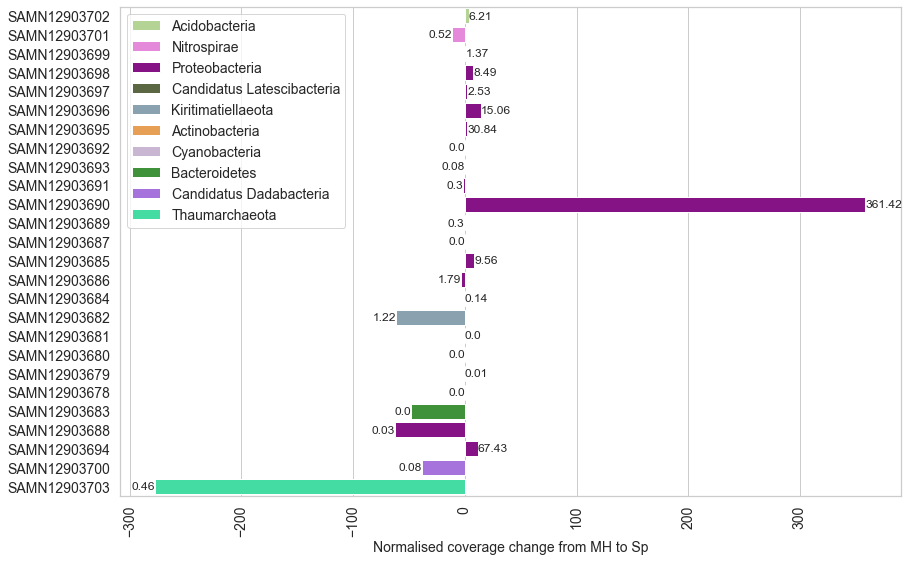

In [49]:
fig, ax = plt.subplots(figsize=(14, 9))
ind = np.arange(26)
p1 = ax.barh(ind, MH_vs_Sp_covstat_df["len_norm_cov_change"])
ax.bar_label(p1, labels=MH_vs_Sp_covstat_df["Sp_len_norm_cov"].round(decimals=2), label_type='edge')
sns.barplot(y=MH_vs_Sp_covstat_df["SAMN"], x=MH_vs_Sp_covstat_df["len_norm_cov_change"], 
           orient='h', hue=MH_vs_Sp_covstat_df["ncbi_phylum"], dodge=False, ax=ax, palette=color_map)
plt.legend(fontsize=14)
plt.xticks(rotation = 90, fontsize=14)
plt.xlabel('Normalised coverage change from MH to Sp', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(None)
# plt.savefig("/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/Metagenome_v_cosmid_final_thesis_MAG_plot_w_numbers.pdf", format="pdf")


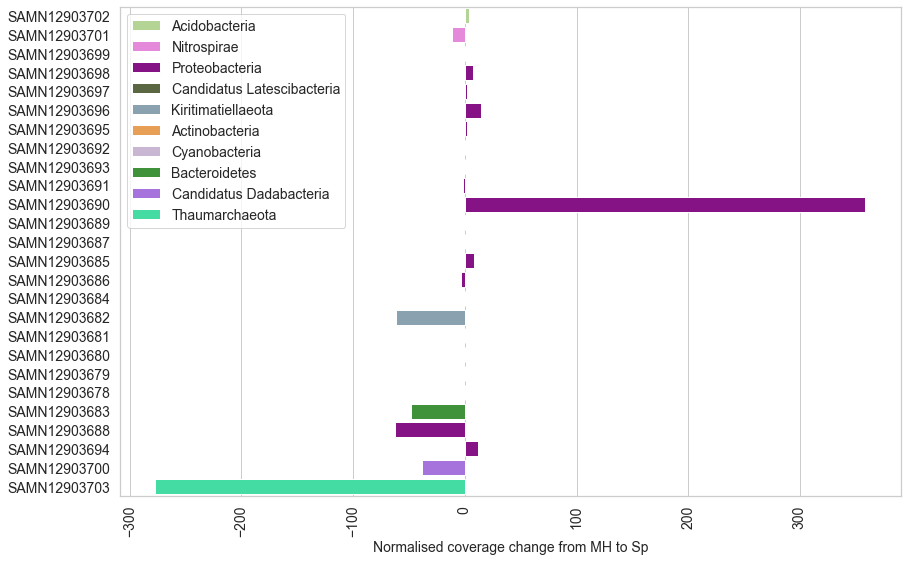

In [104]:
fig, ax = plt.subplots(figsize=(14, 9))
ind = np.arange(26)
#p1 = ax.barh(ind, MH_vs_Sp_covstat_df["len_norm_cov_change"])
#ax.bar_label(p1, labels=MH_vs_Sp_covstat_df["Sp_len_norm_cov"].round(decimals=2), label_type='edge')
sns.barplot(y=MH_vs_Sp_covstat_df["SAMN"], x=MH_vs_Sp_covstat_df["len_norm_cov_change"], 
           orient='h', hue=MH_vs_Sp_covstat_df["ncbi_phylum"], dodge=False, ax=ax, palette=color_map)
plt.legend(fontsize=14)
plt.xticks(rotation = 90, fontsize=14)
plt.xlabel('Normalised coverage change from MH to Sp', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(None)
# plt.savefig("/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/Metagenome_v_cosmid_final_thesis_MAG_plot.pdf", format="pdf")


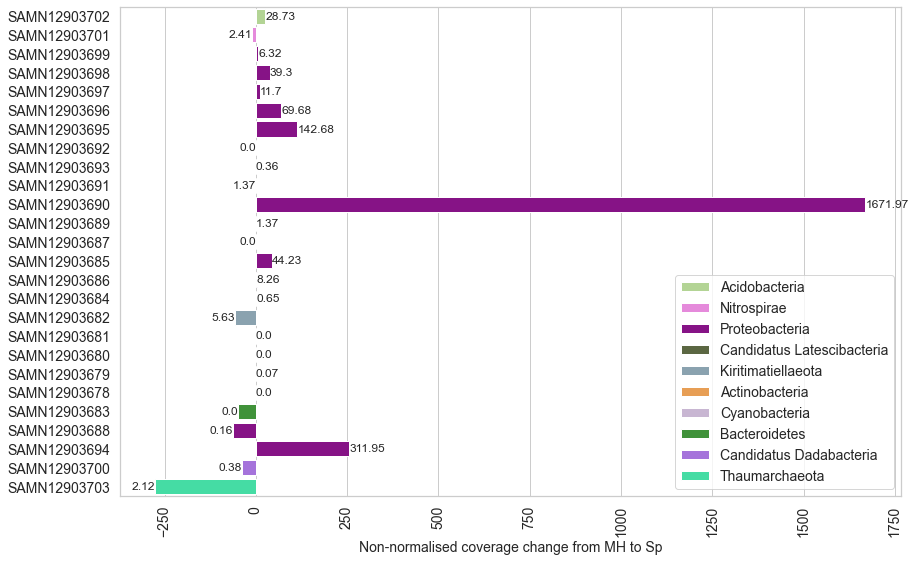

In [66]:
fig, ax = plt.subplots(figsize=(14, 9))
ind = np.arange(26)
p1 = ax.barh(ind, MH_vs_Sp_covstat_df["non_norm_cov_change"])
ax.bar_label(p1, labels=MH_vs_Sp_covstat_df["len_norm_cov_x"].round(decimals=2), label_type='edge')
sns.barplot(y=MH_vs_Sp_covstat_df["SAMN"], x=MH_vs_Sp_covstat_df["non_norm_cov_change"], 
           orient='h', hue=MH_vs_Sp_covstat_df["ncbi_phylum"], dodge=False, ax=ax, palette=color_map)
plt.legend(fontsize=14)
plt.xticks(rotation = 90, fontsize=14)
plt.xlabel('Non-normalised coverage change from MH to Sp', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(None)
# plt.savefig("/Users/vincentn/Documents/PhD/Metagenome_v_cosmid/Metagenome_v_cosmid_final_thesis_MAG_plot_w_numbers_nonnorm.pdf", format="pdf")
